# 1. Data Loading and Initial Exploration

This section covers loading the global weather dataset and performing an initial exploratory data analysis (EDA). We examine the dataset’s structure, variable types, and presence of duplicates, and apply necessary data cleaning steps like standardizing country names. This helps us understand the data and prepare it for further analysis.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.inspection import permutation_importance
from scipy.stats import randint, uniform

### Aux_Functions

In [2]:
def plot_top_and_bottom_categories(df, column, top_n=20, bottom_n=20):
    def plot_counts(subset, title, palette):
        data = subset.reset_index()
        data.columns = [column, 'count']
        sns.barplot(data=data, x='count', y=column, hue=column, palette=palette, legend=False)
        plt.title(title)
        plt.xlabel('Count'); plt.ylabel(column)
        plt.tight_layout(); plt.show()

    counts = df[column].value_counts()
    plt.figure(figsize=(8, 4))
    plot_counts(counts.head(top_n), f'Top {top_n} in "{column}"', 'Blues_r')
    plt.figure(figsize=(8, 4))
    plot_counts(counts.tail(bottom_n), f'Bottom {bottom_n} in "{column}"', 'Greens')

def plot_world_map(df, col, title=None, scale=None, clip_upper=None):
    data = df.copy()
    if clip_upper:
        q = data[col].quantile(clip_upper)
        data = data[data[col] <= q]
    avg = data.groupby('country', as_index=False)[col].mean()
    if not scale:
        scale = (
            'YlOrRd' if 'temperature' in col else
            'blues' if 'humidity' in col else
            'gray_r' if 'air_quality' in col or 'PM' in col else
            'viridis'
        )
    fig = px.choropleth(
        avg, locations='country', locationmode='country names',
        color=col, title=title or f'Average {col} by Country',
        template='plotly_white', color_continuous_scale=scale
    )
    fig.update_layout(showlegend=False)
    fig.show()

def remove_outliers_iqr(df, cols=None, multiplier=1.5):
    df_clean = df.copy()
    if cols is None:
        cols = df.select_dtypes(include='number').columns.tolist()
    for col in cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - multiplier * IQR
        upper = Q3 + multiplier * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean


### Load the dataset

In [3]:
df = pd.read_csv('https://docs.google.com/uc?export=download&id=1NxsuSQECPVvAfUgz0VgVdjNv5eR-aAgL')

### First Explorations

In [4]:
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (70747, 41)


,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [5]:
df.describe()

,latitude,longitude,last_updated_epoch,temperature_celsius,temperature_fahrenheit,wind_mph,wind_kph,wind_degree,pressure_mb,pressure_in,...,gust_kph,air_quality_Carbon_Monoxide,air_quality_Ozone,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,moon_illumination
count,70747.000000,70747.000000,7.074700e+04,70747.000000,70747.000000,70747.000000,70747.000000,70747.000000,70747.000000,70747.000000,...,70747.000000,70747.000000,70747.000000,70747.000000,70747.000000,70747.000000,70747.000000,70747.000000,70747.000000,70747.000000
mean,19.131459,22.169514,1.731611e+09,22.146009,71.864437,8.273309,13.318268,168.503569,1014.088131,29.945404,...,18.905920,525.925443,63.930232,15.365355,11.398992,26.006253,53.568802,1.750873,2.760174,50.343280
std,24.472653,65.830484,9.118910e+06,9.431442,16.976366,8.729757,14.047140,103.651755,12.690370,0.374715,...,15.961526,899.915693,34.887027,26.199893,45.675324,43.191196,164.762452,0.993421,2.608253,35.144371
min,-41.300000,-175.200000,1.715849e+09,-24.900000,-12.800000,2.200000,3.600000,1.000000,947.000000,27.960000,...,3.600000,-9999.000000,0.000000,0.000000,-9999.000000,0.168000,-1848.150000,1.000000,1.000000,0.000000
25%,3.750000,-6.836100,1.723810e+09,16.600000,62.000000,4.000000,6.500000,80.000000,1010.000000,29.830000,...,10.800000,231.250000,41.000000,1.100000,0.740000,6.290000,9.600000,1.000000,1.000000,15.000000
50%,17.250000,23.316700,1.731661e+09,24.500000,76.100000,6.900000,11.200000,160.000000,1013.000000,29.920000,...,16.200000,329.300000,61.000000,3.885000,2.405000,14.430000,21.645000,1.000000,2.000000,51.000000
75%,40.400000,50.580000,1.739527e+09,28.300000,83.000000,11.400000,18.400000,255.000000,1017.000000,30.050000,...,25.100000,512.450000,82.300000,17.020000,9.150000,30.500000,46.805000,2.000000,3.000000,85.000000
max,64.150000,179.220000,1.747300e+09,49.200000,120.600000,1841.200000,2963.200000,360.000000,3006.000000,88.770000,...,2970.400000,38879.398000,480.700000,427.700000,521.330000,1614.100000,6037.290000,6.000000,10.000000,100.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70747 entries, 0 to 70746
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       70747 non-null  object 
 1   location_name                 70747 non-null  object 
 2   latitude                      70747 non-null  float64
 3   longitude                     70747 non-null  float64
 4   timezone                      70747 non-null  object 
 5   last_updated_epoch            70747 non-null  int64  
 6   last_updated                  70747 non-null  object 
 7   temperature_celsius           70747 non-null  float64
 8   temperature_fahrenheit        70747 non-null  float64
 9   condition_text                70747 non-null  object 
 10  wind_mph                      70747 non-null  float64
 11  wind_kph                      70747 non-null  float64
 12  wind_degree                   70747 non-null  int64  
 13  w

In [7]:
duplicates_count = df.duplicated().sum()
print(f"Total duplicate rows: {duplicates_count}")

Total duplicate rows: 0


In [8]:
# Separate by data type
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Count and display
print(f"Number of numerical columns: {len(numerical_cols)}")
print(numerical_cols)

print(f"\nNumber of categorical columns: {len(categorical_cols)}")
print(categorical_cols)


Number of numerical columns: 30
['latitude', 'longitude', 'last_updated_epoch', 'temperature_celsius', 'temperature_fahrenheit', 'wind_mph', 'wind_kph', 'wind_degree', 'pressure_mb', 'pressure_in', 'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius', 'feels_like_fahrenheit', 'visibility_km', 'visibility_miles', 'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'moon_illumination']

Number of categorical columns: 11
['country', 'location_name', 'timezone', 'last_updated', 'condition_text', 'wind_direction', 'sunrise', 'sunset', 'moonrise', 'moonset', 'moon_phase']


Some countries need mapping, we will check all the unique values for countries and locations

In [9]:
# Full list sorted alphabetically
countries = sorted(df['country'].unique(), reverse=True)
print(countries)
locations = sorted(df['location_name'].unique(), reverse = True)
print(locations)

['火鸡', 'كولومبيا', 'Турция', 'Польша', 'Гватемала', 'Zimbabwe', 'Zambia', 'Yemen', 'Vietnam', 'Venezuela', 'Vatican City', 'Vanuatu', 'Uzbekistan', 'Uruguay', 'United States of America', 'United Kingdom', 'United Arab Emirates', 'Ukraine', 'Uganda', 'USA United States of America', 'Tuvalu', 'Turkménistan', 'Turkmenistan', 'Turkey', 'Tunisia', 'Trinidad and Tobago', 'Tonga', 'Togo', 'Timor-Leste', 'Thailand', 'Tanzania', 'Tajikistan', 'Südkorea', 'Syria', 'Switzerland', 'Sweden', 'Swaziland', 'Suriname', 'Sudan', 'Sri Lanka', 'Spain', 'South Korea', 'South Africa', 'Somalia', 'Solomon Islands', 'Slovenia', 'Slovakia', 'Singapore', 'Sierra Leone', 'Seychelles Islands', 'Serbia', 'Senegal', 'Saudi Arabien', 'Saudi Arabia', 'San Marino', 'Samoa', 'Saint-Vincent-et-les-Grenadines', 'Saint Vincent and the Grenadines', 'Saint Lucia', 'Saint Kitts and Nevis', 'Rwanda', 'Russia', 'Romania', 'Qatar', 'Portugal', 'Polônia', 'Poland', 'Philippines', 'Peru', 'Paraguay', 'Papua New Guinea', 'Panama'

In [10]:
# Manual mapping of specific non-latin country names
country_mapping = {
    'Гватемала': 'Guatemala',
    'Польша': 'Poland',
    'Турция': 'Turkey',
    'كولومبيا' : 'Colombia',
    '火鸡': 'Turkey'
}

# Apply the mapping
df['country'] = df['country'].replace(country_mapping)


In [11]:
#Checking the mapping
countries = sorted(df['country'].unique(), reverse=True)
print(countries)
locations = sorted(df['location_name'].unique(), reverse = True)
print(locations)

['Zimbabwe', 'Zambia', 'Yemen', 'Vietnam', 'Venezuela', 'Vatican City', 'Vanuatu', 'Uzbekistan', 'Uruguay', 'United States of America', 'United Kingdom', 'United Arab Emirates', 'Ukraine', 'Uganda', 'USA United States of America', 'Tuvalu', 'Turkménistan', 'Turkmenistan', 'Turkey', 'Tunisia', 'Trinidad and Tobago', 'Tonga', 'Togo', 'Timor-Leste', 'Thailand', 'Tanzania', 'Tajikistan', 'Südkorea', 'Syria', 'Switzerland', 'Sweden', 'Swaziland', 'Suriname', 'Sudan', 'Sri Lanka', 'Spain', 'South Korea', 'South Africa', 'Somalia', 'Solomon Islands', 'Slovenia', 'Slovakia', 'Singapore', 'Sierra Leone', 'Seychelles Islands', 'Serbia', 'Senegal', 'Saudi Arabien', 'Saudi Arabia', 'San Marino', 'Samoa', 'Saint-Vincent-et-les-Grenadines', 'Saint Vincent and the Grenadines', 'Saint Lucia', 'Saint Kitts and Nevis', 'Rwanda', 'Russia', 'Romania', 'Qatar', 'Portugal', 'Polônia', 'Poland', 'Philippines', 'Peru', 'Paraguay', 'Papua New Guinea', 'Panama', 'Palau', 'Pakistan', 'Oman', 'Norway', 'North Kor

The dataset consists of over 70,000 observations with a variety of numerical and categorical variables related to weather and air quality. Initial cleaning addressed inconsistencies in country names to unify the data. Understanding the dataset’s composition is crucial before applying any modeling techniques.

# 2. Exploratory Data Visualization

In this section, we perform a detailed visualization of the dataset to better understand the distributions and temporal trends of key variables. We analyze categorical variables like countries and locations to identify their frequency, explore seasonal changes through monthly averages, and visualize global spatial patterns using choropleth maps. These visualizations help uncover important patterns and potential features for modeling

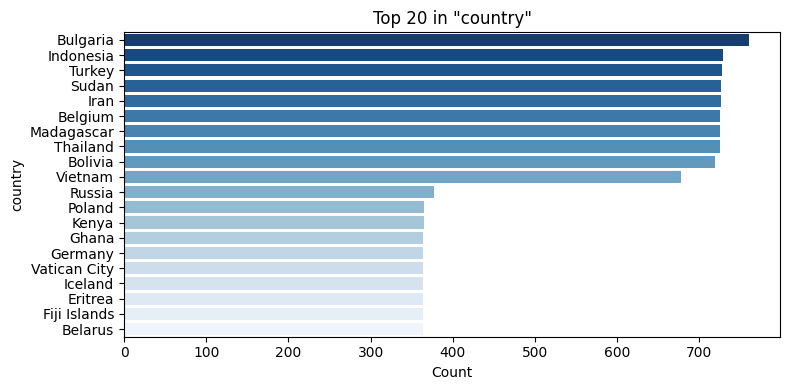

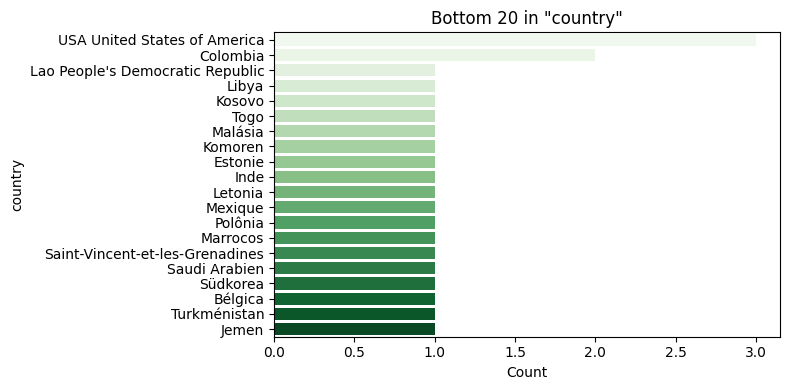

In [12]:
plot_top_and_bottom_categories(df, column='country')


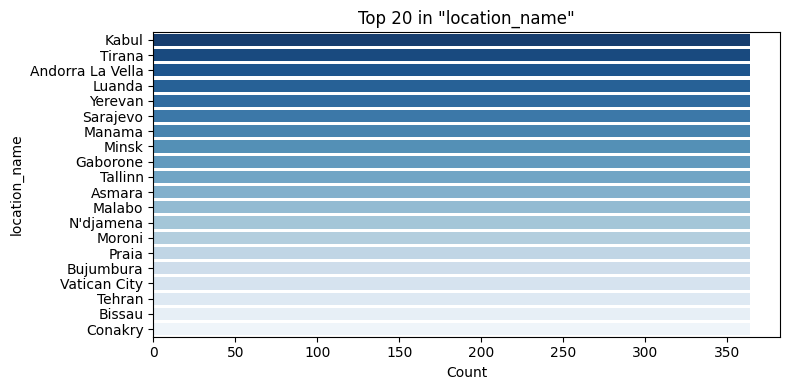

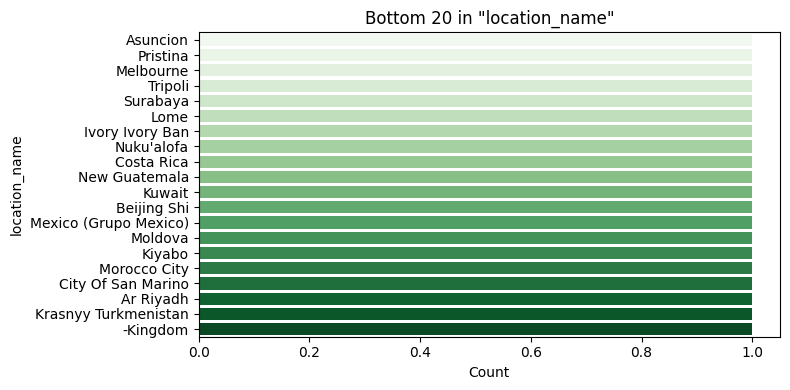

In [13]:
plot_top_and_bottom_categories(df, 'location_name')

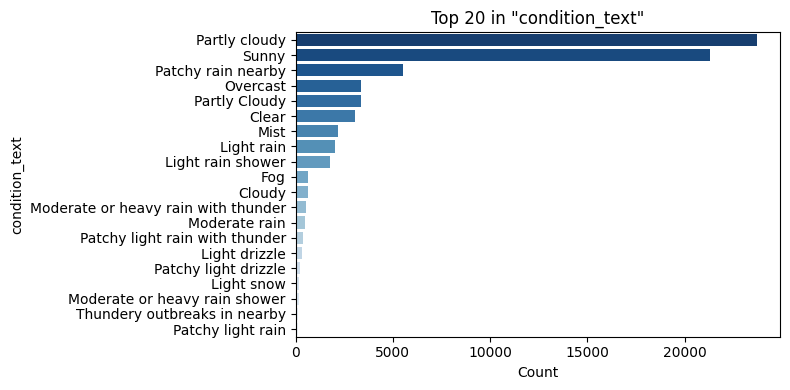

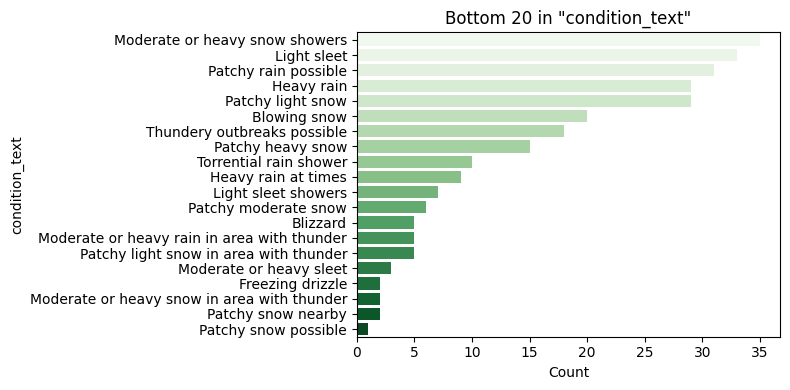

In [14]:
plot_top_and_bottom_categories(df, 'condition_text')

In [15]:
df['last_updated'] = pd.to_datetime(df['last_updated'])
print("Min date:", df['last_updated'].min())
print("Max date:", df['last_updated'].max())


Min date: 2024-05-16 01:45:00
Max date: 2025-05-15 22:00:00


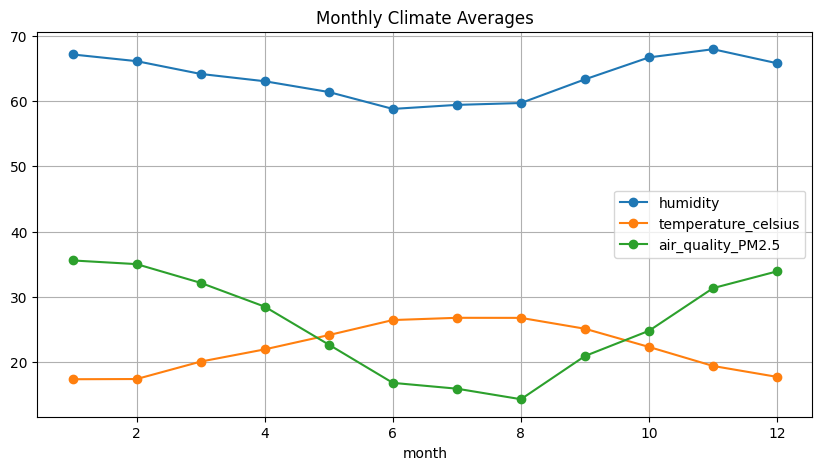

In [16]:
df['month'] = df['last_updated'].dt.month
monthly_avg = df.groupby('month')[['humidity','temperature_celsius', 'air_quality_PM2.5']].mean()
monthly_avg.plot(marker='o', figsize=(10,5), title='Monthly Climate Averages')
plt.grid(True)
plt.show()


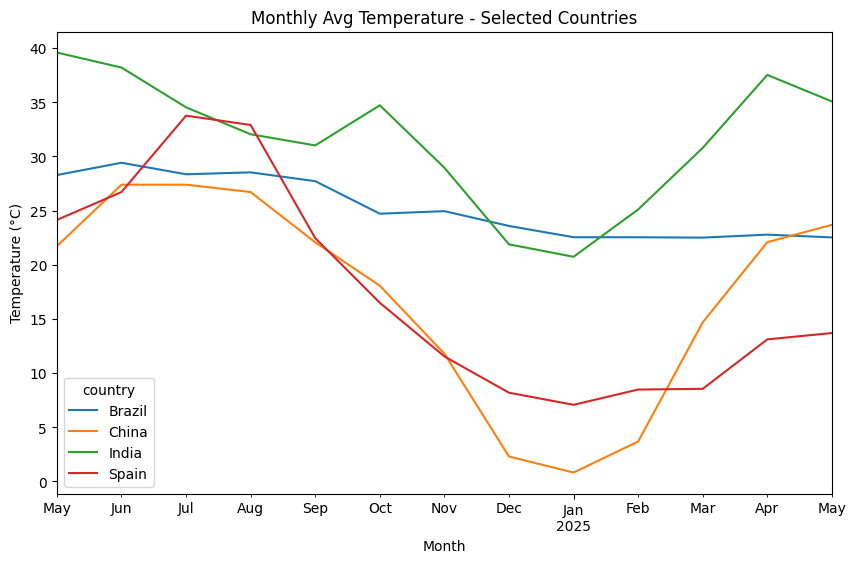

In [17]:
selected_countries = ['China', 'Spain', 'India', 'United States', 'Brazil']
df_filtered = df[df['country'].isin(selected_countries)]

df_filtered = df_filtered.copy()
df_filtered['last_updated'] = pd.to_datetime(df_filtered['last_updated'])
df_grouped = df_filtered.groupby([df_filtered['last_updated'].dt.to_period('M'), 'country'])['temperature_celsius'].mean().unstack()

df_grouped.plot(figsize=(10, 6), title='Monthly Avg Temperature - Selected Countries')
plt.ylabel('Temperature (°C)')
plt.xlabel('Month')
plt.show()


In [18]:
plot_world_map(df, 'temperature_celsius')


In [19]:
plot_world_map(df, 'humidity')

In [20]:
plot_world_map(df, 'air_quality_PM2.5', clip_upper=0.99) #To leave out outliers


## 2.1 Distributions and Relationships of Numerical Variables

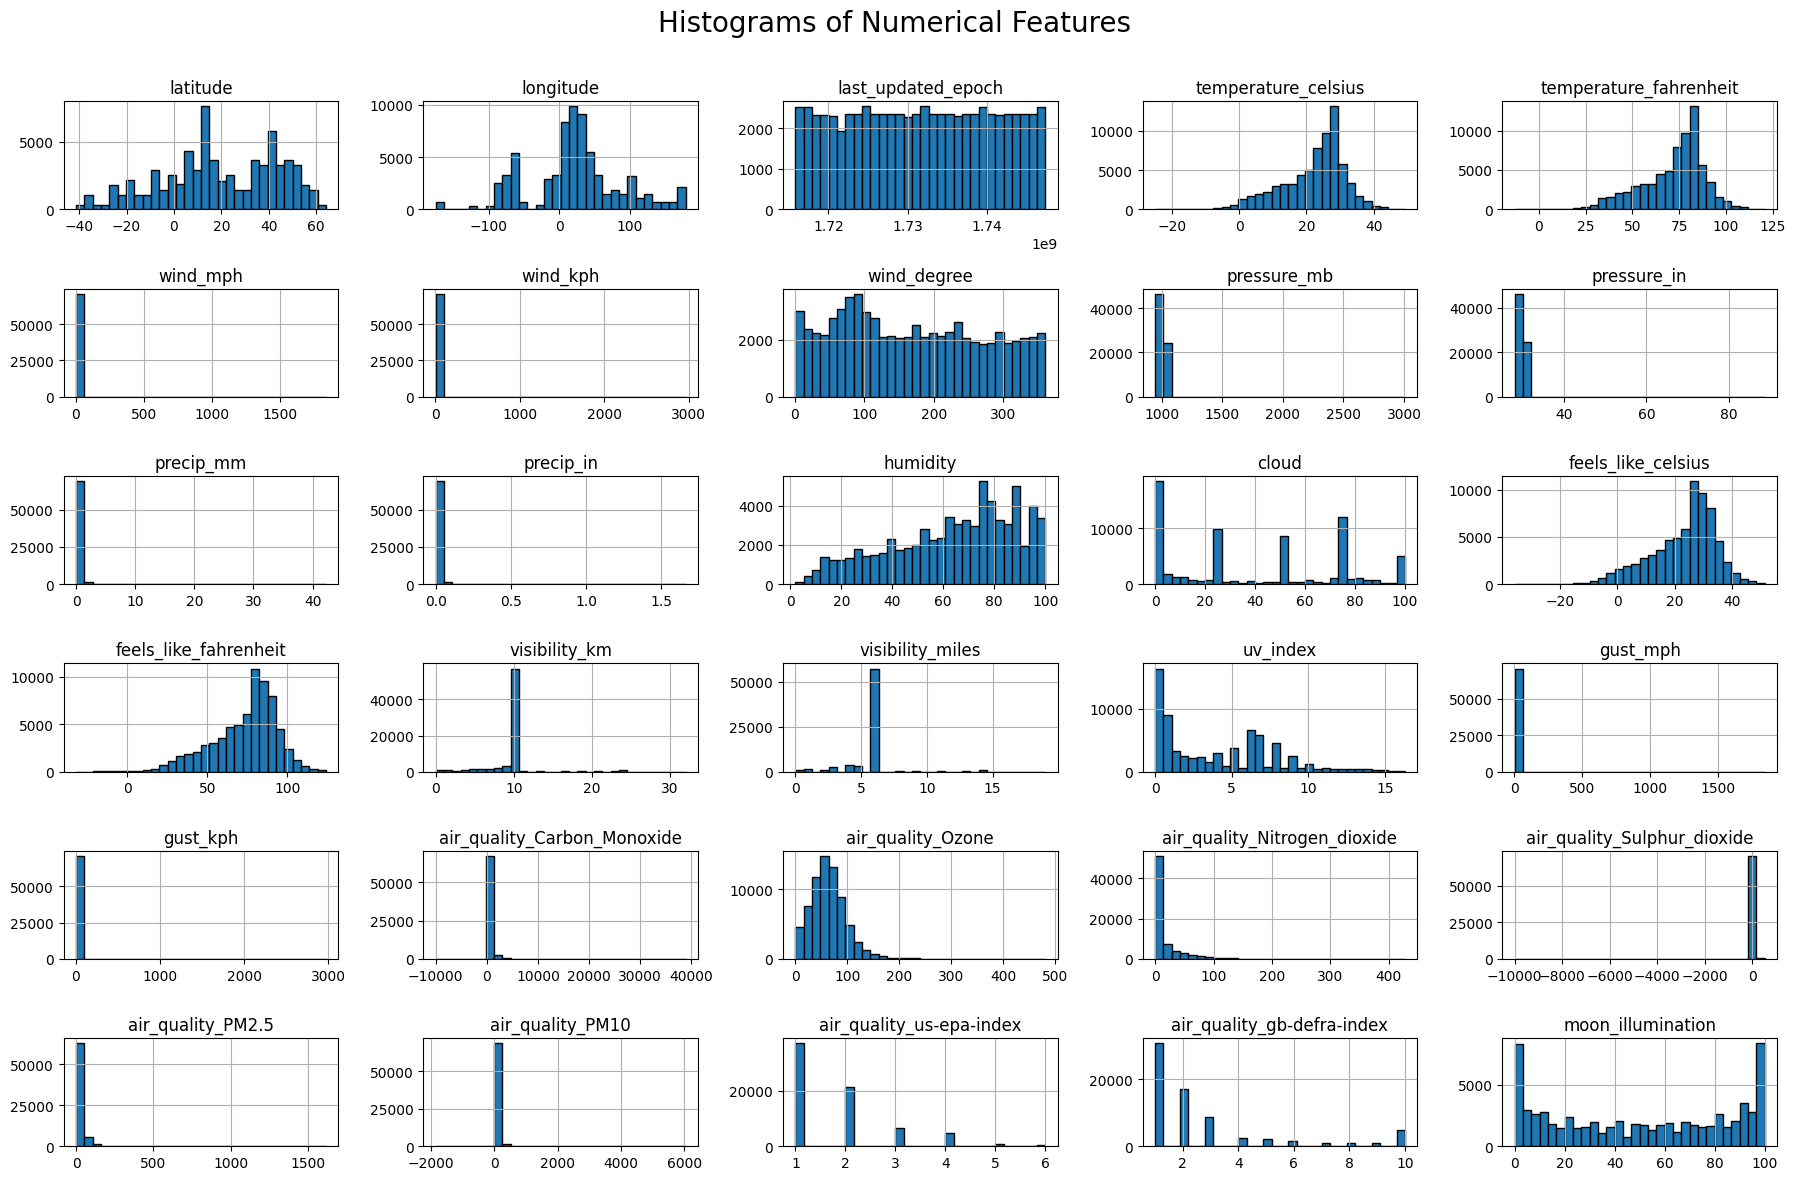

In [21]:
# Plot histograms for all numerical columns
df[numerical_cols].hist(figsize=(18, 12), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Features", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


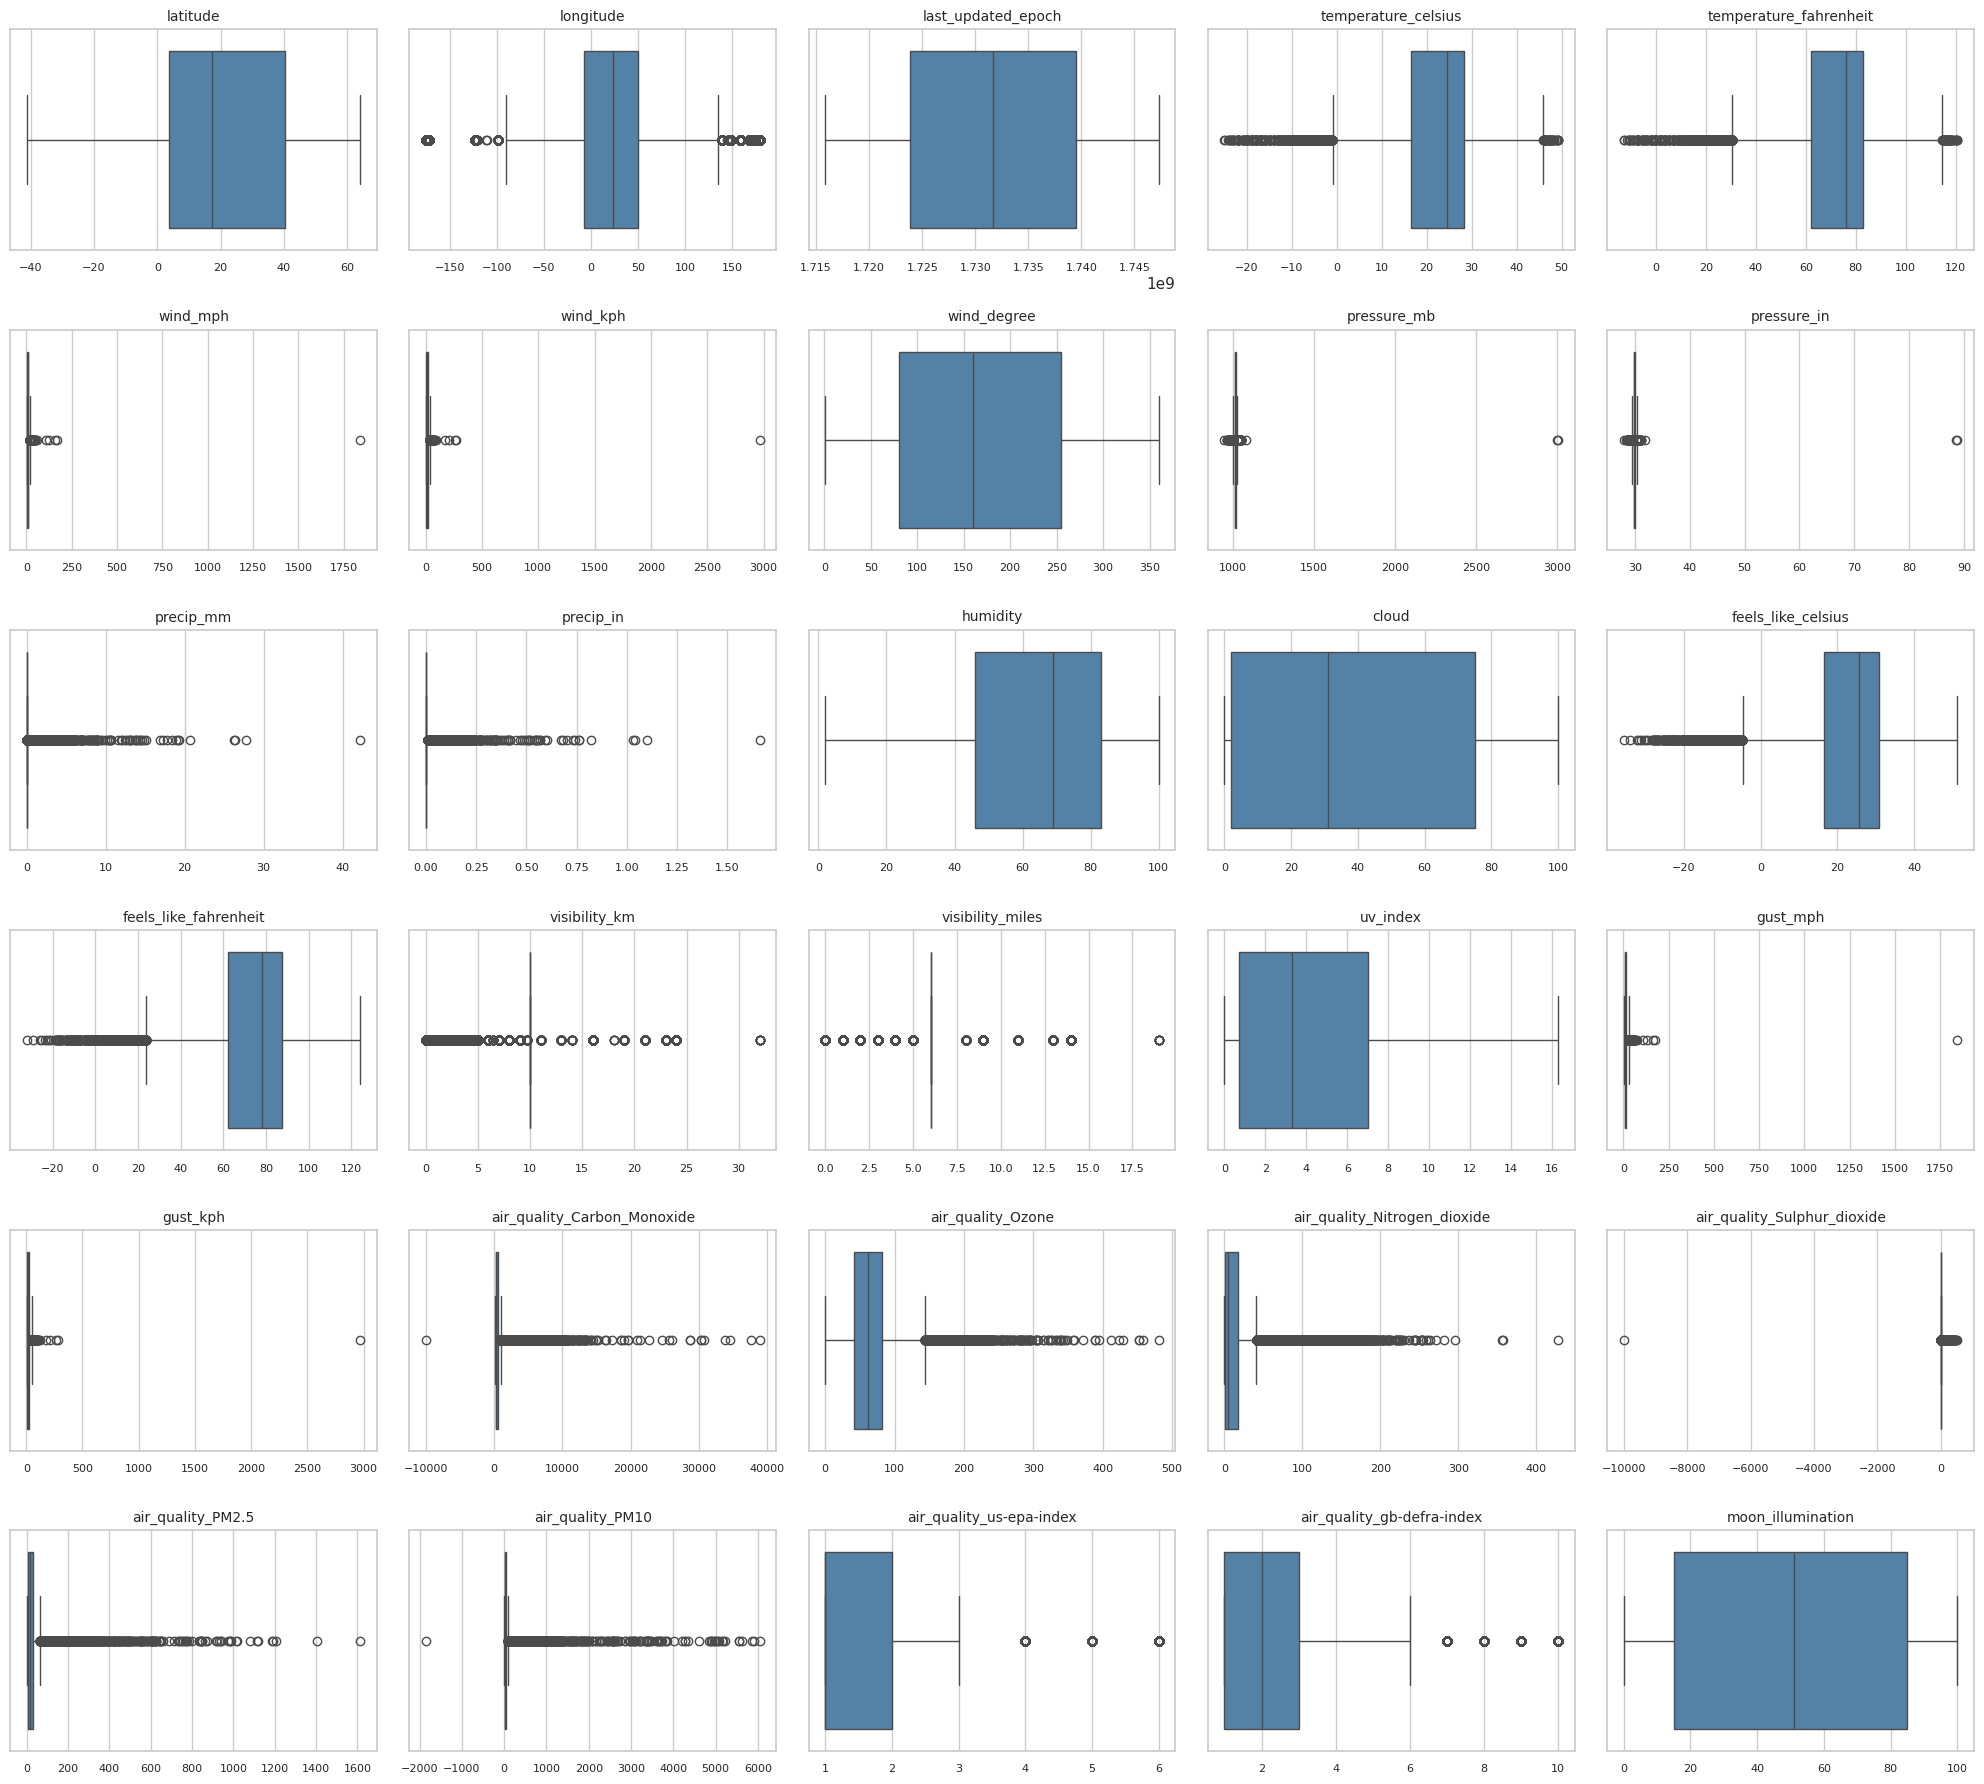

In [22]:
sns.set(style="whitegrid")

# We saw there are 30 numerical columns
n_cols = 5
n_rows = 6

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 18))
axes = axes.flatten()

# Plot boxplots for all numerical columns
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[col], ax=axes[i], color='steelblue')
    axes[i].set_title(col, fontsize=10)
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].set_xlabel("")

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

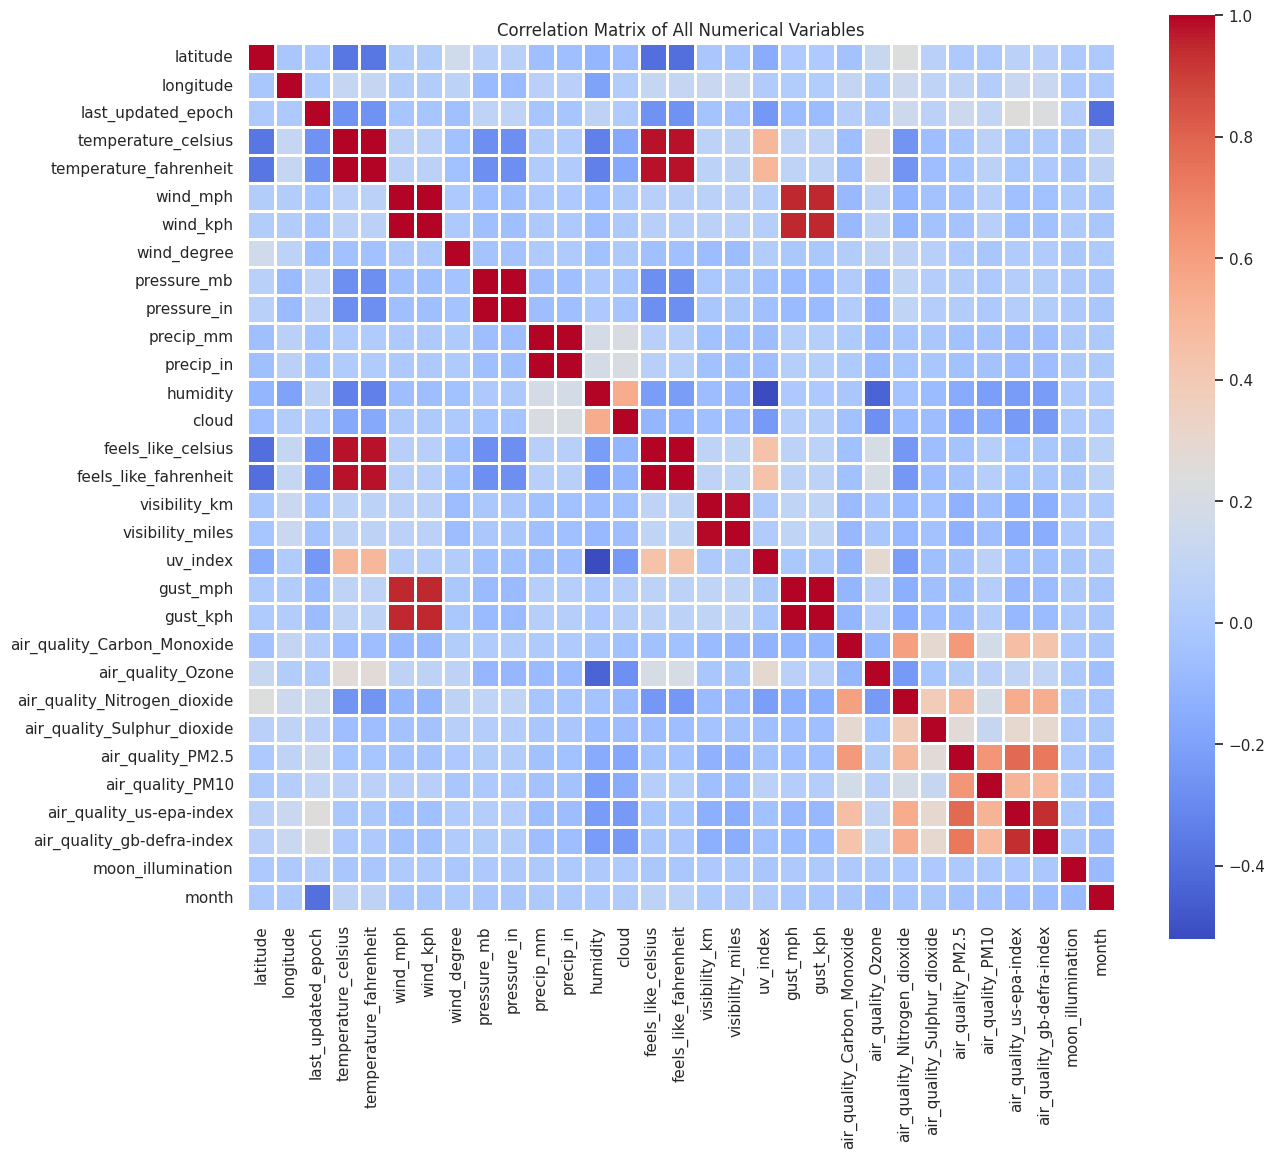

In [23]:
plt.figure(figsize=(14, 12))
sns.heatmap(
    df.select_dtypes(include='number').corr(),
    annot=False,
    cmap='coolwarm',
    square=True,
    linecolor='white',
    linewidth=0.8
)
plt.title('Correlation Matrix of All Numerical Variables')
plt.show()


The distribution plots show that some variables have skewed distributions and noticeable outliers, especially in wind and precipitation measures. These outliers could influence model training if not addressed.

The correlation heatmap highlights strong relationships among several variables, such as temperature in Celsius and Fahrenheit, which justifies removing redundant features. Other meaningful correlations suggest some variables capture similar information.

Understanding these patterns helps guide feature selection and preprocessing to build better, more stable models.

# 3. Data Cleaning: Removal of Redundant Variables

Before modeling, we remove redundant variables that contain the same information in different units, such as temperature in Fahrenheit vs Celsius, wind speed in mph vs kph, and others. This step helps reduce noise and avoids multicollinearity in modeling.

In [24]:
cols_to_drop = [
    'temperature_fahrenheit',
    'feels_like_fahrenheit',
    'wind_mph',
    'precip_in',
    'visibility_miles',
    'pressure_in',
    'gust_mph',
    'air_quality_us-epa-index'

]

df = df.drop(columns=cols_to_drop)


# 4. Modeling

In this section, we build predictive models to estimate temperature in Celsius using the prepared dataset. To avoid data leakage, we remove feels_like_celsius since it closely mirrors the target variable, and exclude last_updated_epoch as it is a timestamp not relevant for prediction. We begin by training baseline models and progressively improve them through hyperparameter tuning.

In [25]:
df_model1 = df.drop(columns=['feels_like_celsius', 'last_updated_epoch']).copy()

### Random Forest

In [26]:
target = 'temperature_celsius'
X = df_model1.select_dtypes(include='number').drop(columns=[target])
y = df_model1[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)

rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
mae_rf = mean_absolute_error(y_val, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf:.4f}")
print(f"Random Forest MAE: {mae_rf:.4f}")


Random Forest RMSE: 1.9221
Random Forest MAE: 1.3066


In [27]:
df_no_outliers = remove_outliers_iqr(df_model1)

target = 'temperature_celsius'
X = df_no_outliers.select_dtypes(include='number').drop(columns=[target])
y = df_no_outliers[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)

rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
mae_rf = mean_absolute_error(y_val, y_pred_rf)

print(f"Random Forest RMSE (no outliers): {rmse_rf:.4f}")
print(f"Random Forest MAE (no outliers): {mae_rf:.4f}")


Random Forest RMSE (no outliers): 1.9924
Random Forest MAE (no outliers): 1.3782


Outlier removal did not improve results significantly, so using full dataset

## XGBoost

In [28]:
!pip install xgboost --upgrade

In [29]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

target = 'temperature_celsius'
X = df_model1.select_dtypes(include='number').drop(columns=[target])
y = df_model1[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_reg = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    tree_method='hist',
    device = "cuda",
    random_state=42,
    n_jobs=-1
)

xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print(f"XGBoost GPU RMSE: {rmse:.4f}")
print(f"XGBoost GPU MAE: {mae:.4f}")


XGBoost GPU RMSE: 1.7451
XGBoost GPU MAE: 1.2172


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning:

[01:08:43] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.




In [30]:
target = 'temperature_celsius'
X = df_model1.select_dtypes(include='number').drop(columns=[target])
y = df_model1[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_reg = xgb.XGBRegressor(
    tree_method='hist',
    device='cuda',
    random_state=42,
    n_jobs=-1
)

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.19),  # 0.01 to 0.2
    'subsample': uniform(0.6, 0.4),        # 0.6 to 1.0
    'colsample_bytree': uniform(0.6, 0.4),# 0.6 to 1.0
    'min_child_weight': randint(1, 10)
}

random_search = RandomizedSearchCV(
    xgb_reg,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=1
)

random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)

best_model = random_search.best_estimator_

y_pred = best_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation MAE: {mae:.4f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.749816047538945, learning_rate=0.19063571821788408, max_depth=13, min_child_weight=8, n_estimators=288, subsample=0.8387400631785948; total time=   7.2s
[CV] END colsample_bytree=0.749816047538945, learning_rate=0.19063571821788408, max_depth=13, min_child_weight=8, n_estimators=288, subsample=0.8387400631785948; total time=   6.0s
[CV] END colsample_bytree=0.749816047538945, learning_rate=0.19063571821788408, max_depth=13, min_child_weight=8, n_estimators=288, subsample=0.8387400631785948; total time=   7.6s
[CV] END colsample_bytree=0.7783331011414365, learning_rate=0.028995234005420548, max_depth=13, min_child_weight=8, n_estimators=216, subsample=0.8404460046972835; total time=   5.3s
[CV] END colsample_bytree=0.7783331011414365, learning_rate=0.028995234005420548, max_depth=13, min_child_weight=8, n_estimators=216, subsample=0.8404460046972835; total time=   5.5s
[CV] END colsample_bytree=0.77

FineTuning

In [31]:
best_params = {
    'n_estimators': 216,
    'max_depth': 13,
    'learning_rate': 0.029,
    'subsample': 0.84,
    'colsample_bytree': 0.78,
    'min_child_weight': 8
}

param_dist_fine = {
    'n_estimators': [200, 210, 216, 220, 230],
    'max_depth': [12, 13, 14],
    'learning_rate': np.linspace(0.025, 0.035, 5),  # 0.025 a 0.035
    'subsample': np.linspace(0.80, 0.88, 5),
    'colsample_bytree': np.linspace(0.75, 0.82, 5),
    'min_child_weight': [7, 8, 9]
}

xgb_reg = xgb.XGBRegressor(
    tree_method='hist',
    device='cuda',
    random_state=42,
    n_jobs=-1
)

random_search_fine = RandomizedSearchCV(
    xgb_reg,
    param_distributions=param_dist_fine,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=1
)

random_search_fine.fit(X_train, y_train)

print("Best fine-tuned params:", random_search_fine.best_params_)

best_model_fine = random_search_fine.best_estimator_

y_pred_fine = best_model_fine.predict(X_val)
rmse_fine = np.sqrt(mean_squared_error(y_val, y_pred_fine))
mae_fine = mean_absolute_error(y_val, y_pred_fine)

print(f"Fine-tuned Validation RMSE: {rmse_fine:.4f}")
print(f"Fine-tuned Validation MAE: {mae_fine:.4f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.75, learning_rate=0.0325, max_depth=14, min_child_weight=8, n_estimators=216, subsample=0.8; total time=   5.9s
[CV] END colsample_bytree=0.75, learning_rate=0.0325, max_depth=14, min_child_weight=8, n_estimators=216, subsample=0.8; total time=   6.1s
[CV] END colsample_bytree=0.75, learning_rate=0.0325, max_depth=14, min_child_weight=8, n_estimators=216, subsample=0.8; total time=   5.9s
[CV] END colsample_bytree=0.82, learning_rate=0.0325, max_depth=14, min_child_weight=9, n_estimators=220, subsample=0.8; total time=   5.8s
[CV] END colsample_bytree=0.82, learning_rate=0.0325, max_depth=14, min_child_weight=9, n_estimators=220, subsample=0.8; total time=   5.7s
[CV] END colsample_bytree=0.82, learning_rate=0.0325, max_depth=14, min_child_weight=9, n_estimators=220, subsample=0.8; total time=   5.8s
[CV] END colsample_bytree=0.82, learning_rate=0.0325, max_depth=12, min_child_weight=9, n_estimator

# 6. Final Model Selection and Interpretation

After extensive experimentation and hyperparameter tuning, we select the best-performing XGBoost model based on validation RMSE and MAE. This final model is trained on the full training dataset using the optimized hyperparameters. We then evaluate its performance on the validation set and interpret the model by analyzing feature importance via permutation importance, which provides insight into which variables most influence temperature predictions.

In [32]:
best_model = random_search_fine.best_estimator_

y_pred = best_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print(f"Validation RMSE (best estimator): {rmse:.4f}")
print(f"Validation MAE (best estimator): {mae:.4f}")


Validation RMSE (best estimator): 1.6812
Validation MAE (best estimator): 1.1697


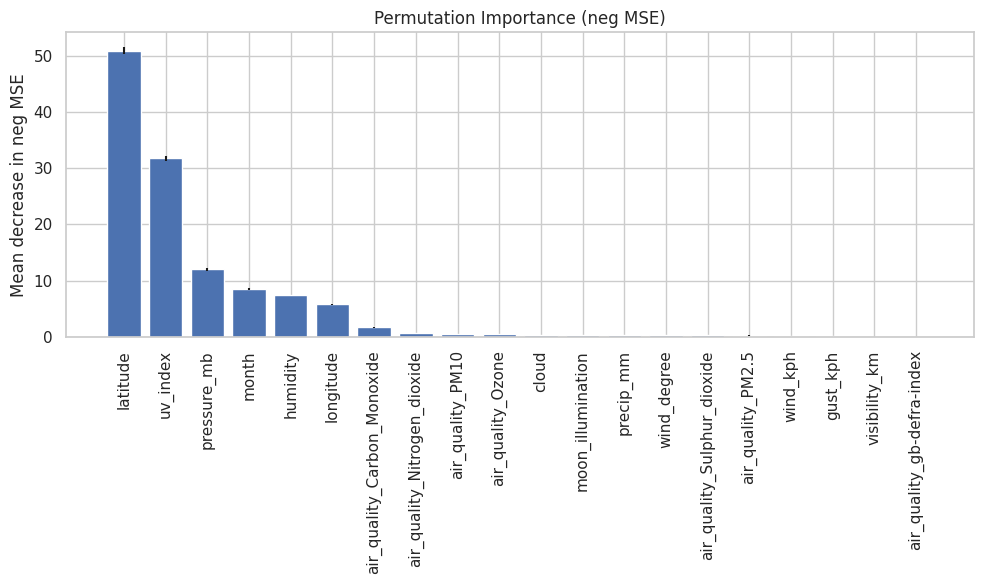

In [33]:
result = permutation_importance(
    best_model_fine, X_val, y_val,
    n_repeats=10, random_state=42, n_jobs=-1, scoring='neg_mean_squared_error'
)

importances = result.importances_mean
std = result.importances_std
indices = np.argsort(importances)[::-1]

features = X_val.columns

plt.figure(figsize=(10, 6))
plt.title("Permutation Importance (neg MSE)")
plt.bar(range(len(importances)), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.ylabel("Mean decrease in neg MSE")
plt.tight_layout()
plt.show()
